# Pruebas estad√≠sicas - Complemento a la predicci√≥n

**Autor:** Jazna Meza Hidalgo

**Correo Electr√≥nico:** ja.meza@profesor.duoc.cl

**Fecha de Creaci√≥n:** Diciembre de 2024  
**Versi√≥n:** 1.0  

---

## Descripci√≥n

Este notebook ofrece un complemento al trabajo de la predicci√≥n del monto de los costos m√©dicos.

Realiza test estad√≠sticos que respaldan y amplian los hallazgos de la matroz de correlaci√≥n.

Las pruebas estad√≠sticas que se realizan son:

1. Prueba t de Student para comparar medias.
2. An√°lisis de varianza ANOVA
3. Pruebas de correlaci√≥n para variables continuas
4. Pruebas de normalidad (Shapizo-Wilk)
---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuaci√≥n se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)

Para verificar la versi√≥n instalada ejecutar usando el siguiente comando, usando la librer√≠a de la cual quieres saber la versi√≥n:

```bash
import pandas as pd
print(pd.__version__)
````

In [17]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, f_oneway, pearsonr, spearmanr, shapiro
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
!wget https://www.dropbox.com/s/6xn8hxmo16f25qc/insurance.csv

--2024-12-30 19:42:52--  https://www.dropbox.com/s/6xn8hxmo16f25qc/insurance.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/unto7vjrswe6u4w1nukvx/insurance.csv?rlkey=yr81nii85hmym91r9qdpzh76l [following]
--2024-12-30 19:42:53--  https://www.dropbox.com/scl/fi/unto7vjrswe6u4w1nukvx/insurance.csv?rlkey=yr81nii85hmym91r9qdpzh76l
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca3796a19c97436e3f4699081f1.dl.dropboxusercontent.com/cd/0/inline/ChR_45uHC6VAbQ_7jqhNhwT1SWrJKmsIW2iAVJQ50v0MWQ-cQgMaZYz7Vfw_h9uS6G0vVi8EKQHK3gkH-kiYUnnU0aElZVqyPZCle5u7QVlD1ah1aSpX_QCwmLctBBvjeqzc94gvnNO70gKhSPf1Nu7c/file# [following]
--2024-12-30 19:42:53--  https://uca3796a19c97436e3f4699081f1.dl.dropboxusercontent.com/cd/0/inlin

In [3]:
data_frame = pd.read_csv("insurance.csv")
data_frame

age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]

In [4]:
data_frame = data_frame.drop_duplicates()

In [5]:
data_x = pd.get_dummies(data_frame[["sex", "region", "smoker"]], prefix = ["sex", "region", "smoker"])
data_x.head()

sex_female  sex_male  region_northeast  region_northwest  region_southeast  \
0        True     False             False             False             False   
1       False      True             False             False              True   
2       False      True             False             False              True   
3       False      True             False              True             False   
4       False      True             False              True             False   

   region_southwest  smoker_no  smoker_yes  
0              True      False        True  
1             False       True       False  
2             False       True       False  
3             False       True       False  
4             False       True       False

In [6]:
data_x = pd.concat([
    data_frame.drop(["sex", "region", "smoker"], axis = 1),
    data_x
], axis = 1)
data_x.head()

age     bmi  children      charges  sex_female  sex_male  region_northeast  \
0   19  27.900         0  16884.92400        True     False             False   
1   18  33.770         1   1725.55230       False      True             False   
2   28  33.000         3   4449.46200       False      True             False   
3   33  22.705         0  21984.47061       False      True             False   
4   32  28.880         0   3866.85520       False      True             False   

   region_northwest  region_southeast  region_southwest  smoker_no  smoker_yes  
0             False             False              True      False        True  
1             False              True             False       True       False  
2             False              True             False       True       False  
3              True             False             False       True       False  
4              True             False             False       True       False

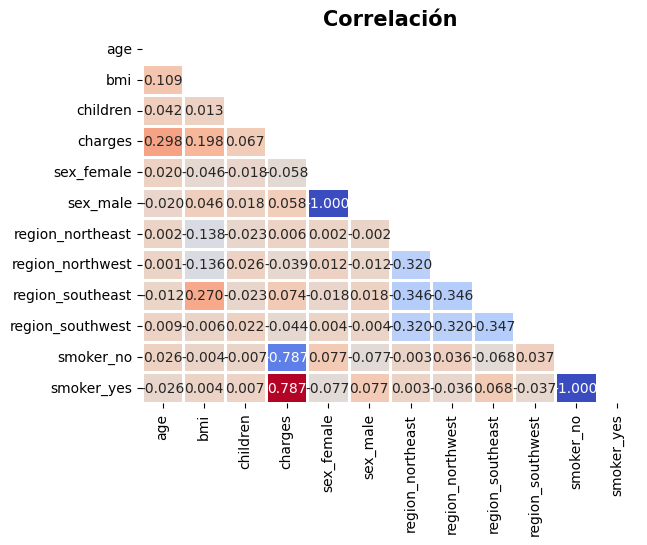

In [7]:
corrMatrix = data_x.corr(numeric_only=True)
mask = np.triu(corrMatrix)
sns.heatmap(corrMatrix,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            mask=mask,
            linewidths=1,
            cbar=False)
plt.title("Correlaci√≥n", fontsize=15, fontweight="bold")
plt.show()

In [8]:
# Variables clave
categorical_vars = ['sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
continuous_vars = ['age', 'bmi']
target = 'charges'

# Prueba t de Student

**Objetivo.** Evaluar si hay diferencias significativas en los costos (charges) entre los grupos binarios de variables como smoker y sex.

**Ejemplo**

+ Comparar los costos medios entre fumadores (smoker_yes) y no fumadores (smoker_no).
+ Comparar los costos medios entre hombres (sex_male) y mujeres (sex_female).

**Hip√≥tesis**

+ H0: No hay diferencias significativas entre los grupos (las medias de charges son iguales).
+ H1: Hay diferencias significativas entre los grupos (las medias de *charges* son diferentes).

In [11]:
print("Prueba t de Student: smoker vs. charges")
smoker_yes = data_x[data_x['smoker_yes'] == 1][target]
smoker_no = data_x[data_x['smoker_no'] == 1][target]
t_stat, p_val_ttest = ttest_ind(smoker_yes, smoker_no)
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val_ttest:.9f}")


Prueba t de Student: smoker vs. charges
T-statistic: 46.64, p-value: 0.000000000




---
**Interpretaci√≥n**


---

Un T-statistic de 46.64 y un p-value extremadamente bajo (pr√°cticamente 0) indican que existe una diferencia estad√≠sticamente significativa entre los costos m√©dicos (charges) de fumadores y no fumadores.

**T-statistic (46.64)**

+ Este valor mide cu√°ntas desviaciones est√°ndar separan las medias de los dos grupos (fumadores y no fumadores).
+ Un valor tan alto sugiere una gran diferencia entre las medias de los costos m√©dicos de los dos grupos.

**p-value (pr√°cticamente 0)**

+ Un p-value tan peque√±o significa que la probabilidad de observar una diferencia tan grande (o mayor) entre las medias debido al azar es pr√°cticamente nula.

+ Si usamos un nivel de significancia t√≠pico (por ejemplo, Œ±=0.05), se rechaza la hip√≥tesis nula ($ùêª_0$).

**Hip√≥tesis en la prueba t de Student**

+ $ùêª_0$ (hip√≥tesis nula): no hay diferencia en los costos m√©dicos entre fumadores y no fumadores (las medias son iguales).
+ $ùêª_1$ (hip√≥tesis alternativa): existe una diferencia en los costos m√©dicos entre fumadores y no fumadores (las medias son diferentes).

**Conclusi√≥n**
Se rechaza $ùêª_0$. Existe evidencia estad√≠stica s√≥lida de que los fumadores y no fumadores tienen costos m√©dicos significativamente diferentes.

**Implicaciones pr√°cticas**

+ Diferencia clara en los costos. Los fumadores tienen costos m√©dicos notablemente m√°s altos, lo que indica que fumar tiene un impacto considerable en los gastos m√©dicos.

+ Tama√±o del efecto. Para cuantificar la magnitud de esta diferencia, se puede calcular la d de Cohen (medida del tama√±o del efecto). **Un valor de d mayor a 0.8 indica un tama√±o del efecto grande.**



In [13]:
mean_yes = np.mean(smoker_yes)
mean_no = np.mean(smoker_no)
std_combined = np.sqrt(((np.std(smoker_yes)**2) + (np.std(smoker_no)**2)) / 2)
cohen_d = (mean_yes - mean_no) / std_combined
print(f"Cohen's d: {cohen_d:.2f}")

Cohen's d: 2.57


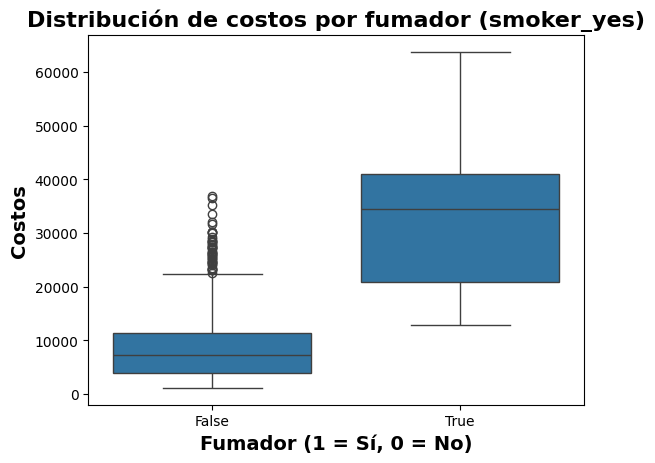

In [15]:
sns.boxplot(x='smoker_yes', y='charges', data=data_x)
plt.title('Distribuci√≥n de costos por fumador (smoker_yes)', fontsize=16, fontweight="bold")
plt.xlabel('Fumador (1 = S√≠, 0 = No)', fontsize=14, fontweight="bold")
plt.ylabel('Costos', fontsize=14, fontweight="bold")
plt.show()

# Test de ANOVA

**Objetivo.** Evaluar si los costos (charges) difieren significativamente entre las regiones (region_northeast, region_northwest, etc.).

**Hip√≥tesis**
+ $H_0$: Las medias de charges son iguales en todas las regiones.
+ $H_1$: Al menos una regi√≥n tiene una media de charges diferente.


In [20]:
# Identificar las columnas dummies relacionadas con la regi√≥n
dummies = [col for col in data_x.columns if col.startswith('region_')]

# Reconstruir la variable categ√≥rica original
data_x['region'] = data_x[dummies].idxmax(axis=1).str.replace('region_', '')

# Verificar la nueva columna
print(data_x['region'].head())

0    southwest
1    southeast
2    southeast
3    northwest
4    northwest
Name: region, dtype: object


In [22]:
# Agrupar los valores de charges por regi√≥n

grouped_regions = [data_x[data_x['region'] == region]['charges'] for region in data_x['region'].unique()]

# Calcular ANOVA
f_stat, p_value = f_oneway(*grouped_regions)
print("Prueba ANOVA: region vs. charges")
print(f"F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")

Prueba ANOVA: region vs. charges
F-statistic: 2.93, p-value: 0.0328


---

**Interpretaciones**

---

**F-statistic (2.93)**

+ El estad√≠stico F mide la relaci√≥n entre la variabilidad explicada por las diferencias entre las regiones y la variabilidad dentro de las regiones.
+ Un valor m√°s alto de F indica que las diferencias entre las medias de las regiones son m√°s grandes en comparaci√≥n con la variabilidad interna.

**p-value (0.0328)**

Dado que el p-value es menor que el nivel de significancia t√≠pico (ùõº=0.05), se rechaza la hip√≥tesis nula ($ùêª_0$).

**Hip√≥tesis en ANOVA**

+ $ùêª_0$: Las medias de charges son iguales para todas las regiones.
+ $ùêª_1$: Al menos una regi√≥n tiene una media de charges diferente.

**Conclusi√≥n**

Existe evidencia estad√≠stica de que los costos m√©dicos (charges) var√≠an seg√∫n la regi√≥n.

**Influencia de la regi√≥n**

La regi√≥n parece tener un efecto estad√≠sticamente significativo en los costos m√©dicos. Esto sugiere que factores geogr√°ficos o relacionados con la regi√≥n pueden influir en los gastos m√©dicos.

**Identificaci√≥n de diferencias espec√≠ficas**

La prueba ANOVA indica que hay diferencias significativas entre las regiones, pero no especifica cu√°les regiones difieren. Es necesario realizar una prueba post hoc, como Tukey HSD, para identificar las diferencias.



In [23]:
tukey = pairwise_tukeyhsd(endog=data_x['charges'], groups=data_x['region'], alpha=0.05)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1    group2   meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------------
northeast northwest  -955.5437 0.7457 -3397.7353  1486.648  False
northeast southeast  1329.0269 0.4746 -1045.1237 3703.1776  False
northeast southwest -1059.4471 0.6793 -3499.7595 1380.8652  False
northwest southeast  2284.5706 0.0643     -89.58 4658.7212  False
northwest southwest  -103.9035 0.9995 -2544.2158 2336.4088  False
southeast southwest -2388.4741 0.0477 -4760.6915  -16.2567   True
-----------------------------------------------------------------


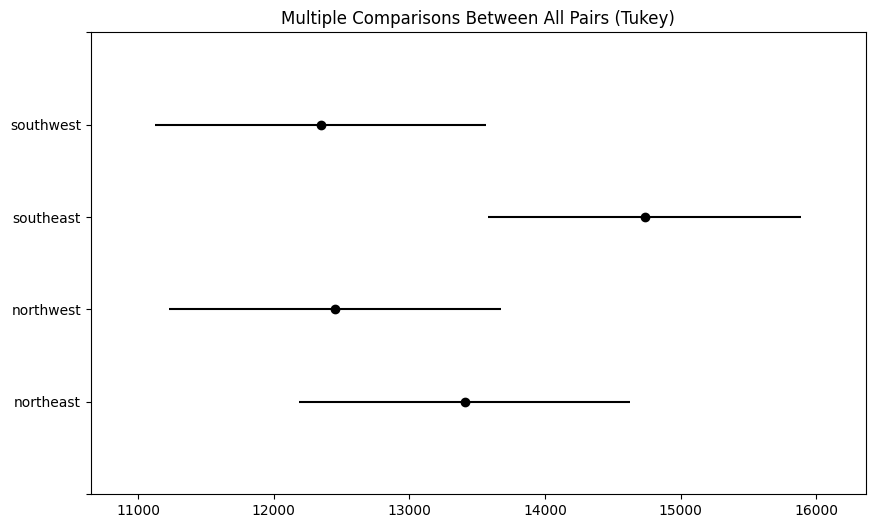

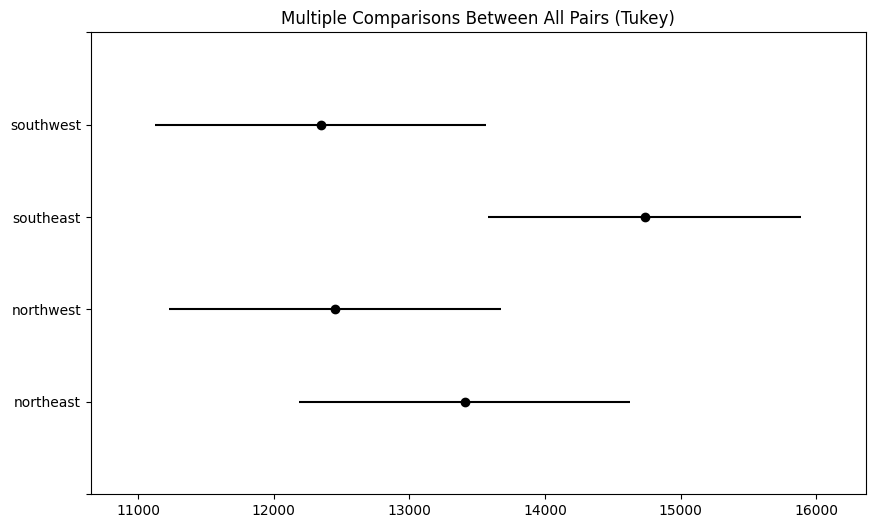

In [24]:
# Visualizaci√≥n del resumen
tukey.plot_simultaneous()

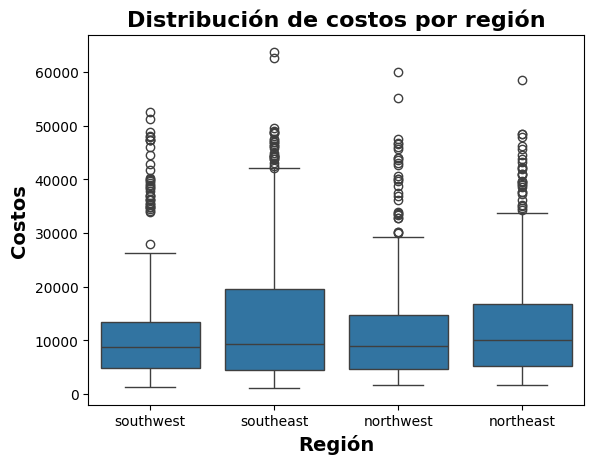

In [25]:
sns.boxplot(x='region', y='charges', data=data_x)
plt.title('Distribuci√≥n de costos por regi√≥n', fontsize=16, fontweight="bold")
plt.xlabel('Regi√≥n', fontsize=14, fontweight="bold")
plt.ylabel('Costos', fontsize=14, fontweight="bold")
plt.show()

---
**COMENTARIO FINAL**

---
Este resultado sugiere que factores asociados a la ubicaci√≥n geogr√°fica (como acceso a servicios m√©dicos, diferencias en costos de vida, o patrones de salud regionales) pueden influir en los costos m√©dicos. Esto podr√≠a ser relevante para pol√≠ticas de salud o estudios sobre desigualdades regionales.

# Pruebas de correlaci√≥n

+ Usar correlaci√≥n de Pearson para confirmar la relaci√≥n entre variables continuas como age o bmi con charges.
+ Si los datos no cumplen con la normalidad, usar correlaci√≥n de Spearman como alternativa.


In [29]:
print("Correlaci√≥n (Pearson y Spearman): variables continuas vs. charges")
for variable in continuous_vars:
    pearson_corr, p_val_pearson = pearsonr(data_x[variable], data_x[target])
    spearman_corr, p_val_spearman = spearmanr(data_x[variable], data_x[target])
    print(f"{variable} - Pearson: {pearson_corr:.2f} (p={p_val_pearson:.4f}), Spearman: {spearman_corr:.2f} (p={p_val_spearman:.4f})")


Correlaci√≥n (Pearson y Spearman): variables continuas vs. charges
age - Pearson: 0.30 (p=0.0000), Spearman: 0.53 (p=0.0000)
bmi - Pearson: 0.20 (p=0.0000), Spearman: 0.12 (p=0.0000)


---
**Interpretaciones**

---

**Correlaci√≥n entre age y charges**

**Pearson: 0.30 (p=0.0000)**

Esto indica una correlaci√≥n positiva moderada entre la edad y los cargos m√©dicos. A medida que aumenta la edad, los cargos m√©dicos tienden a aumentar.

El p-valor (0.0000) indica que la correlaci√≥n es estad√≠sticamente significativa.

**Spearman: 0.53 (p=0.0000)**

Esto indica una correlaci√≥n positiva m√°s fuerte desde una perspectiva no lineal. Spearman eval√∫a relaciones mon√≥tonas (donde los valores aumentan o disminuyen consistentemente, aunque no sea lineal). Esto sugiere que, aunque la relaci√≥n entre edad y cargos m√©dicos no sea perfectamente lineal, hay una tendencia clara de que los cargos aumentan con la edad.

El p-valor confirma la significancia estad√≠stica de esta relaci√≥n.

**Conclusi√≥n sobre age**

La edad tiene un impacto significativo en los cargos m√©dicos, y esta relaci√≥n es m√°s fuerte al analizarla desde una perspectiva no lineal (Spearman). Esto puede reflejar que, a medida que las personas envejecen, tienden a requerir m√°s atenci√≥n m√©dica y, por ende, sus cargos aumentan.

**Correlaci√≥n entre bmi y charges**

**Pearson: 0.20 (p=0.0000)**

Esto indica una correlaci√≥n positiva d√©bil entre el √≠ndice de masa corporal (BMI) y los cargos m√©dicos. A medida que aumenta el BMI, los cargos m√©dicos tienden a aumentar, aunque la relaci√≥n no es tan fuerte como en el caso de la edad.

El p-valor indica que esta correlaci√≥n es estad√≠sticamente significativa.
Spearman: 0.12 (p=0.0000)

Esto indica una correlaci√≥n a√∫n m√°s d√©bil desde una perspectiva no lineal. Esto sugiere que el impacto del BMI en los cargos m√©dicos es menor y puede no ser constante en todos los rangos de BMI.

El p-valor confirma la significancia estad√≠stica.

**Conclusi√≥n sobre BMI**

Aunque el BMI tiene una relaci√≥n positiva con los cargos m√©dicos, su impacto es mucho menor en comparaci√≥n con la edad. Esto podr√≠a reflejar que el BMI por s√≠ solo no es un fuerte determinante de los cargos m√©dicos, aunque podr√≠a interactuar con otras variables, como la presencia de comorbilidades.

**Comparaci√≥n entre Pearson y Spearman**

La correlaci√≥n de Pearson mide relaciones lineales, mientras que Spearman mide relaciones mon√≥tonas (que no necesariamente son lineales).

En el caso de age, la diferencia entre Pearson (0.30) y Spearman (0.53) sugiere que la relaci√≥n entre edad y cargos m√©dicos podr√≠a no ser completamente lineal, pero s√≠ consistente en su tendencia creciente.

Para BMI, las correlaciones de Pearson y Spearman son m√°s cercanas (0.20 vs. 0.12), lo que indica que la relaci√≥n, aunque d√©bil, es principalmente lineal.


**Impacto de la edad**

La edad es una variable significativa y relevante para predecir los cargos m√©dicos. Esto sugiere que las personas mayores tienden a incurrir en mayores gastos m√©dicos, probablemente debido a un aumento en la frecuencia de enfermedades relacionadas con la edad.

**Impacto del BMI**

El BMI tiene un impacto menor, pero a√∫n significativo. Esto podr√≠a reflejar que el √≠ndice de masa corporal, aunque relevante para ciertos problemas de salud, no explica tanto la variabilidad en los cargos m√©dicos como la edad.

**Recomendaci√≥n**

Considerar la edad como una de las variables m√°s importantes en el modelo predictivo.

Evaluar la interacci√≥n del BMI con otras variables, como el h√°bito de fumar o la presencia de enfermedades cr√≥nicas, para entender mejor su impacto.

# Prueba de normalidad (Shapiro-Wilk)

In [28]:
print("Prueba de normalidad (Shapiro-Wilk): charges")
stat, p_val_shapiro = shapiro(data_x[target])
print(f"Estad√≠stico: {stat:.2f}, p-value: {p_val_shapiro:.9f}")

Prueba de normalidad (Shapiro-Wilk): charges
Estad√≠stico: 0.81, p-value: 0.000000000


---
**Comentarios**

---

El resultado de la prueba de normalidad Shapiro-Wilk indica si los datos de la variable *charges* siguen una distribuci√≥n normal.

**Estad√≠stico: 0.81**

Este valor mide la desviaci√≥n de los datos respecto a una distribuci√≥n normal. Cuanto m√°s cercano est√© a 1, m√°s se asemejan los datos a una distribuci√≥n normal.

**p-valor: 0.000000000**

Este valor se utiliza para tomar la decisi√≥n sobre la hip√≥tesis nula. La hip√≥tesis nula de la prueba Shapiro-Wilk es:

$H_0$: Los datos de charges provienen de una distribuci√≥n normal.

Si el p-valor es menor que un umbral com√∫n (como 0.05), se rechaza la hip√≥tesis nula, lo que indica que los datos no tienen una distribuci√≥n normal.

Dado que el p-valor es mucho menor que 0.05, es posible concluir que los datos de *charges* no siguen una distribuci√≥n normal. Esto tiene implicaciones importantes para el an√°lisis estad√≠stico:

**Elecci√≥n de pruebas estad√≠sticas**

Muchas pruebas estad√≠sticas (como ANOVA o la prueba t de Student) asumen que los datos siguen una distribuci√≥n normal. Si esta suposici√≥n no se cumple, los resultados de estas pruebas podr√≠an ser poco confiables.

En este caso, se deber√≠a considerar usar pruebas no param√©tricas, que no requieren normalidad en los datos. Por ejemplo:

+Prueba de Kruskal-Wallis como alternativa a ANOVA.
+Prueba de Mann-Whitney U como alternativa a la prueba t de Student.

**Transformaci√≥n de datos**

Si es necesario utilizar m√©todos que asuman normalidad, se podr√≠a transformar los datos para acercarlos a una distribuci√≥n normal. Algunas transformaciones comunes incluyen:

+Transformaci√≥n logar√≠tmica (log(x)).
+Transformaci√≥n de ra√≠z cuadrada (sqrt(x)).
+Transformaci√≥n Box-Cox (requiere valores positivos).

**Implicaciones en el modelo predictivo**

Si se van a construir modelos predictivos (como regresi√≥n lineal o √°rboles de decisi√≥n, que justamente es el caso), la falta de normalidad en la variable objetivo podr√≠a afectar el rendimiento de los modelos basados en suposiciones lineales.

